In [26]:
from PIL import Image
import numpy as np
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [27]:
from google.colab import files
uploaded = files.upload()

Saving P3_example.jpg to P3_example (1).jpg


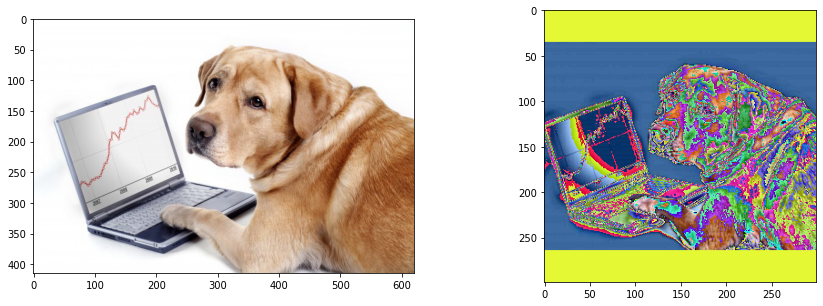

In [184]:
#Se importa la imagen y se le hacen las transformaciones correspondientes


transform = transforms.Compose([transforms.Resize(229),
                                transforms.CenterCrop(299),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])

img=Image.open('P3_example.jpg').convert('RGB') 
img_t=transform(img)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(transforms.ToPILImage()(img_t))
plt.show()

In [29]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import decode_predictions
from torchvision import models
import torch

#Se carga y entrena la red Inception V3

model= models.inception_v3(pretrained=True)
batch_t=torch.unsqueeze(img_t,0)



Predicted: [[('n02099712', 'Labrador_retriever', 7.7844286), ('n03832673', 'notebook', 5.516463), ('n03642806', 'laptop', 5.2327914), ('n02087394', 'Rhodesian_ridgeback', 4.5654774), ('n02099601', 'golden_retriever', 4.15773), ('n02090379', 'redbone', 4.076495), ('n02099849', 'Chesapeake_Bay_retriever', 3.7044892), ('n02108422', 'bull_mastiff', 3.6777244), ('n06359193', 'web_site', 3.6208372), ('n02088466', 'bloodhound', 3.3072798)]]


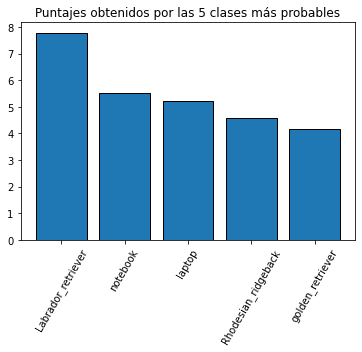

In [209]:
#Se hacen las predicciones para la imagen de control
#Se imprimen las diez primeras predicciones y se grafican los puntajes de los 
#5 primeros

model.eval()
preds = model(batch_t)
print('Predicted:', decode_predictions(preds.detach().numpy(), top=10))


labels=[]
scores=np.zeros(5)
for i in range(5):
  labels.append(decode_predictions(preds.detach().numpy(), top=10)[0][i][1])
  scores[i]=decode_predictions(preds.detach().numpy(), top=10)[0][i][2]

plt.bar(range(5), scores, edgecolor='black')

plt.xticks(range(5), labels, rotation=60)
plt.title("Puntajes obtenidos por las 5 clases más probables")
plt.show()

In [219]:
from skimage.segmentation import slic
#Crea el slic pedido, arreglo 299 x 299
slic_1=slic(transforms.ToPILImage()(img_t),n_segments=80)
n_cat=np.amax(slic_1)  #Se generaron 36 categorias (clusters del 0 al 35)

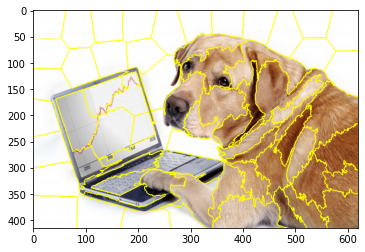

In [33]:
from skimage.segmentation import slic
from skimage import segmentation
#Visualizacion del Slic

slic = slic(img, n_segments=80)

plt.figure
plt.imshow(segmentation.mark_boundaries(img, slic))


plt.show()

In [35]:
#Crear perturbaciones

n_pert=1000

perturbaciones={} #Diccionario con las perturbaciones

for i in range (n_pert):
  perturbaciones[i]=np.random.binomial(size=n_cat+1, n=1, p= 0.5)



In [211]:

#Se crean las imagenes perturbadas, se guardan en el diccionario imgs_pert


imgs_pert={}
img_t_copy=img_t.detach().numpy()


#Para cada perturbacion, se le agrega una nueva capa a la imagen de control. 
#Esta nueva capa tiene el arreglo con los clusters, y en el caso que el cluster
#correspondiente tenga un 0 en la perturbación, se reemplaza el valor por un 999.
#En la imagen de control, si la nueva capa tiene un 999, se reemplazan todos los pixeles
#correspondientes por un 0.


for i in range(n_pert):
  aux=np.copy(slic_1)
  pert=perturbaciones[i]
  for j in range(n_cat+1):
     if pert[j]==0:
        aux[aux==j]=999
  img_pert=np.zeros((4,299,299))
  img_pert[0,:,:]=aux
  img_pert[[1,2,3],:,:]=img_t_copy
  img_pert[1][img_pert[0]==999]=0
  img_pert[2][img_pert[0]==999]=0
  img_pert[3][img_pert[0]==999]=0
  imgs_pert[i]=torch.tensor(img_pert[[1,2,3]],dtype=torch.float32)
      


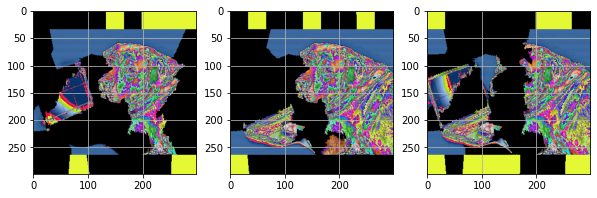

In [176]:
#Se muestran 3 imagenes perturbadas


fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for ax, i in zip(axs, np.random.randint(1,1000,3)):
    ax.imshow(transforms.ToPILImage()(imgs_pert[i]))
    ax.grid(True)

plt.show()



In [215]:
#Se hacen las predicciones usando InceptionV3 para cada imagen perturbada, 
#y se forma el arreglo y, con un 1 si se clasifico como "labrador_retriever"
#y 0 si no

y=np.zeros(n_pert)
clas_expected=labels[0]


for i in range(n_pert):
  batch_t=torch.unsqueeze(imgs_pert[i],0)
  pred=model(batch_t)
  clas=decode_predictions(pred.detach().numpy())[0][0][1]
  if clas== clas_expected:
    y[i]=1


In [228]:
#Se calcula la distancia coseno y los pesos asociados a cada vector de perturbaciones vs. 
#el vector de perturbacion de la imagen de control (un vector de 1s)
from numpy import linalg as LA

sigma=0.25
dist=np.zeros(n_pert)

for i in range(n_pert):
  dist[i]=1 - np.dot(perturbaciones[i],np.ones(n_cat+1))/(LA.norm(perturbaciones[i])*LA.norm(np.ones(n_cat+1)))

pi=np.exp(-np.square(dist)/sigma**2)


array([0.103652  , 0.40945445, 0.40945445, 0.40945445, 0.13388749,
       0.35434044, 0.01831564, 0.58346193, 0.30210416, 0.25345145,
       0.46662607, 0.20895029, 0.13388749, 0.20895029, 0.07822461,
       0.103652  , 0.30210416, 0.25345145, 0.46662607, 0.35434044,
       0.25345145, 0.20895029, 0.52494903, 0.30210416, 0.46662607,
       0.46662607, 0.30210416, 0.20895029, 0.35434044, 0.30210416,
       0.30210416, 0.16901332, 0.16901332, 0.40945445, 0.13388749,
       0.103652  , 0.35434044, 0.20895029, 0.46662607, 0.40945445,
       0.20895029, 0.16901332, 0.30210416, 0.103652  , 0.0407531 ,
       0.20895029, 0.16901332, 0.25345145, 0.46662607, 0.30210416,
       0.30210416, 0.16901332, 0.20895029, 0.25345145, 0.46662607,
       0.35434044, 0.35434044, 0.25345145, 0.0407531 , 0.05737626,
       0.46662607, 0.40945445, 0.25345145, 0.35434044, 0.25345145,
       0.16901332, 0.25345145, 0.16901332, 0.30210416, 0.25345145,
       0.40945445, 0.25345145, 0.58346193, 0.13388749, 0.20895

In [226]:
2**3

8